## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [28]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [29]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [30]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [31]:
len(fmnist_dataset_test)

10000

In [32]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [38]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [39]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Your experiments come here:

In [40]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here


def epoch(model, train_loader, optimizer, loss_func, device=device):
    model.train()
    total_loss = total_correct = total = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_func(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    
    return total_loss / total, total_correct / total


def accuracy(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

def fit(model, train_loader, test_loader, optimizer, loss_func,  epochs=10, device=device,):
    hist = {"train_loss": [], "train_acc": [], "test_acc": []}

    for e in range(epochs):
        tr_loss, tr_acc = epoch(model, train_loader, optimizer, loss_func)
        test_acc = accuracy(model, test_loader, device)

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_acc"].append(test_acc)

        print(f"{(e+1):02d}: loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | test_acc={test_acc:.4f}")

    return hist

hist = fit(model, train_loader, test_loader, opt, loss_func)

01: loss=0.5647 | train_acc=0.8045 | test_acc=0.8175
02: loss=0.3901 | train_acc=0.8590 | test_acc=0.8604
03: loss=0.3469 | train_acc=0.8738 | test_acc=0.8682
04: loss=0.3195 | train_acc=0.8825 | test_acc=0.8727
05: loss=0.3002 | train_acc=0.8893 | test_acc=0.8735
06: loss=0.2835 | train_acc=0.8949 | test_acc=0.8721
07: loss=0.2714 | train_acc=0.8986 | test_acc=0.8776
08: loss=0.2606 | train_acc=0.9019 | test_acc=0.8798
09: loss=0.2501 | train_acc=0.9063 | test_acc=0.8802
10: loss=0.2387 | train_acc=0.9099 | test_acc=0.8849


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [51]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [52]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 2048]       8,390,656
              ReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
              ReLU-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 14,234,122
Trainable params: 14,234,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 54.30
Esti

In [53]:
from torch.utils.data import Subset

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
size = 250  
idx = torch.randperm(len(fmnist_dataset_train))[:size]
small_train_ds = Subset(fmnist_dataset_train, idx)

small_train_loader = torch.utils.data.DataLoader(
    small_train_ds, batch_size=128, shuffle=True, num_workers=2
)

over_hist = fit(model, small_train_loader, test_loader, opt, loss_func, epochs=30)

01: loss=2.2753 | train_acc=0.2080 | test_acc=0.2899
02: loss=1.8626 | train_acc=0.3440 | test_acc=0.2332
03: loss=1.7597 | train_acc=0.2760 | test_acc=0.3796
04: loss=1.3941 | train_acc=0.4160 | test_acc=0.5048
05: loss=1.1709 | train_acc=0.5560 | test_acc=0.4780
06: loss=1.0386 | train_acc=0.5680 | test_acc=0.5520
07: loss=0.8592 | train_acc=0.6680 | test_acc=0.6090
08: loss=0.7358 | train_acc=0.7080 | test_acc=0.6482
09: loss=0.7529 | train_acc=0.7160 | test_acc=0.6190
10: loss=0.8412 | train_acc=0.6920 | test_acc=0.6923
11: loss=0.6360 | train_acc=0.7600 | test_acc=0.7234
12: loss=0.4323 | train_acc=0.8560 | test_acc=0.6502
13: loss=0.4309 | train_acc=0.8440 | test_acc=0.6609
14: loss=0.3638 | train_acc=0.8800 | test_acc=0.7134
15: loss=0.2712 | train_acc=0.9120 | test_acc=0.7418
16: loss=0.2655 | train_acc=0.9120 | test_acc=0.7044
17: loss=0.2217 | train_acc=0.9360 | test_acc=0.7206
18: loss=0.1829 | train_acc=0.9400 | test_acc=0.7047
19: loss=0.1363 | train_acc=0.9560 | test_acc=

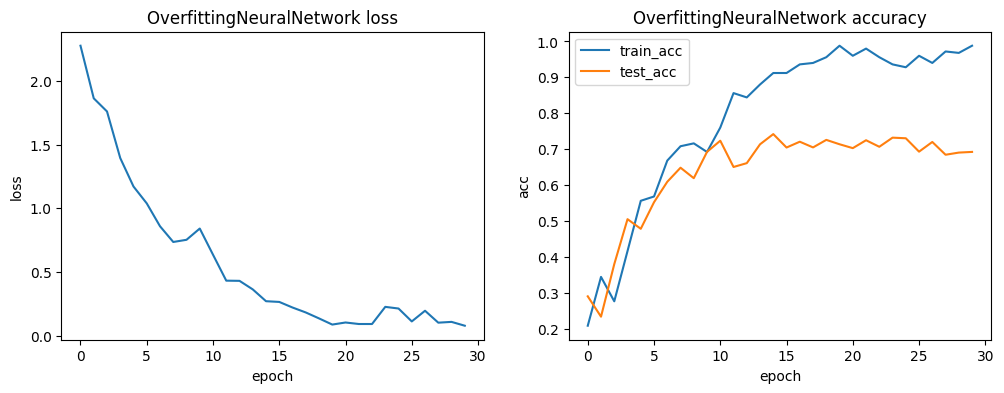

In [71]:
def plot_history(hist, title=""):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist["train_loss"])
    plt.title(title + " loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["test_acc"], label="test_acc")
    plt.title(title + " accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

plot_history(over_hist, title="OverfittingNeuralNetwork")

loss скачет в хвосте, уменьшается неохотно. Высокий train_acc и низкий test_acc говорят о переобучении. Пик test_acc приходится на эпоху 15, дальше идет на спад

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [84]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.65),
            
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [85]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 2048]       8,390,656
       BatchNorm1d-7                 [-1, 2048]           4,096
              ReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 1024]       2,098,176
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                  [

In [86]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
fixed_hist = fit(model, small_train_loader, test_loader, opt, loss_func, epochs=30)

01: loss=2.2990 | train_acc=0.1640 | test_acc=0.3358
02: loss=1.9989 | train_acc=0.3280 | test_acc=0.4740
03: loss=1.6678 | train_acc=0.4120 | test_acc=0.4583
04: loss=1.3696 | train_acc=0.5600 | test_acc=0.5146
05: loss=1.1547 | train_acc=0.6320 | test_acc=0.5772
06: loss=1.0108 | train_acc=0.6760 | test_acc=0.6154
07: loss=0.9544 | train_acc=0.6920 | test_acc=0.6384
08: loss=0.8745 | train_acc=0.7280 | test_acc=0.6451
09: loss=0.7607 | train_acc=0.7400 | test_acc=0.6577
10: loss=0.7451 | train_acc=0.7280 | test_acc=0.6692
11: loss=0.6569 | train_acc=0.7840 | test_acc=0.6772
12: loss=0.5833 | train_acc=0.7920 | test_acc=0.6780
13: loss=0.5418 | train_acc=0.8240 | test_acc=0.6768
14: loss=0.5415 | train_acc=0.8240 | test_acc=0.6877
15: loss=0.4884 | train_acc=0.8280 | test_acc=0.6994
16: loss=0.4122 | train_acc=0.8680 | test_acc=0.7091
17: loss=0.3675 | train_acc=0.9040 | test_acc=0.7168
18: loss=0.3298 | train_acc=0.8920 | test_acc=0.7217
19: loss=0.3416 | train_acc=0.8800 | test_acc=

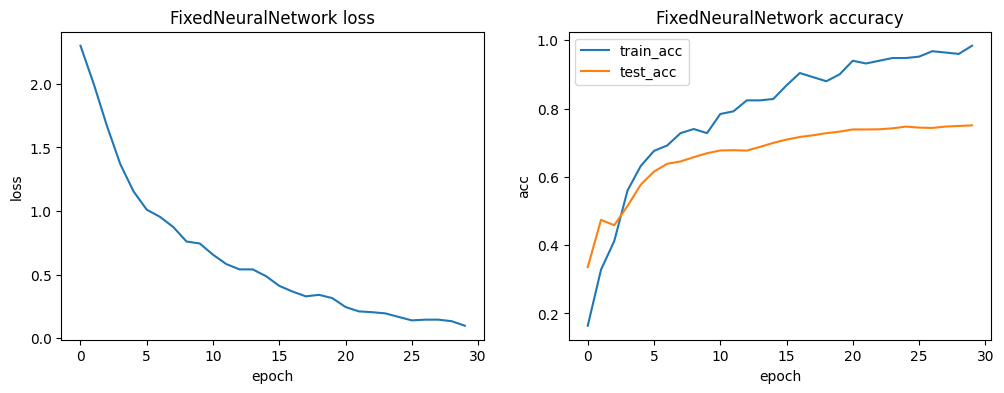

In [88]:
plot_history(fixed_hist, "FixedNeuralNetwork")

### Conclusions:
_Write down small report with your conclusions and your ideas._

Агрессивный DropDown, нормализация и регуляризация в оптимизаторе помогли побороться с  переобучением даже на такой маленькой(250 объектов) обучаемой выборке.  
test_acc стал стабильнее расти в хвосте. Однако, вряд дли получится сильно улучшить test_acc без увеличения выборки. Можно сказать что большое количество слоев без регуляризации, маленькая выборка и большое кол-во эпох заставляет сеть лучше запоминать конкретные примеры и хуже апроксимировать